In [9]:
import boto3
import csv
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from io import StringIO
import io

In [2]:
# Define s3 client:
s3 = boto3.client('s3') # Define or request credentials to place under credencials txt .aws local folder

# Define bucket file variables:
ddi_filename = 'ddi_metadata.csv'
fitz_filename = 'fitzpatrick17k.csv'
folder_name = 'raw_data/metadata/date=27-03-2024/'
s3_bucket = 'provafinalproject-test'

# Retrieve CSV files from S3:
ddi_csv_object = s3.get_object(Bucket=s3_bucket, Key=folder_name + ddi_filename)
fitz_csv_object = s3.get_object(Bucket=s3_bucket, Key=folder_name + fitz_filename)

# Read CSV contents:
ddi_csv_content = ddi_csv_object['Body'].read().decode('utf-8')
fitz_csv_content = fitz_csv_object['Body'].read().decode('utf-8')

# Convert CSV contents to DataFrame:
df_ddi = pd.read_csv(StringIO(ddi_csv_content))
df_fitz = pd.read_csv(StringIO(fitz_csv_content))

# Inspect datasets
print('DDI info:')
print(df_ddi.info())
print()
print('Fitzpatrick info:')
print(df_fitz.info())
print()
print('DDI head:')
print(df_ddi.head(5))
print()
print('Fitzpatrick head:')
print(df_fitz.head(5))

DDI info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  656 non-null    int64 
 1   DDI_ID      656 non-null    int64 
 2   DDI_file    656 non-null    object
 3   skin_tone   656 non-null    int64 
 4   malignant   656 non-null    bool  
 5   disease     656 non-null    object
dtypes: bool(1), int64(3), object(2)
memory usage: 26.4+ KB
None

Fitzpatrick info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16577 entries, 0 to 16576
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   md5hash                16577 non-null  object
 1   fitzpatrick_scale      16577 non-null  int64 
 2   fitzpatrick_centaur    16577 non-null  int64 
 3   label                  16577 non-null  object
 4   nine_partition_label   16577 non-null  object
 5   three_partit

In [3]:
# Merge datasets:
df_merged = pd.DataFrame(index=range(len(df_ddi) + len(df_fitz)), columns=["filename", "skin_tone", "malignant", "path"])
df_merged['filename'] = df_ddi['DDI_file'].tolist() + df_fitz['md5hash'].tolist()
df_merged['filename'] = df_merged['filename'].apply(lambda x: x + ".jpg" if not x.endswith(".png") else x)

df_merged['skin_tone'] = df_ddi['skin_tone'].tolist() + df_fitz['fitzpatrick_scale'].tolist()
df_merged['skin_tone'] = df_merged['skin_tone'].replace([1, 2], 12).replace([3, 4], 34).replace([5, 6], 56)

df_merged['malignant'] = df_ddi['malignant'].tolist() + df_fitz['three_partition_label'].tolist()
df_merged['malignant'] = df_merged['malignant'].replace(['malignant'], True).replace(['non-neoplastic', 'benign'], False)

df_merged['path'] = [folder_name + ddi_filename] * len(df_ddi) + [folder_name + fitz_filename] * len(df_fitz)

df_merged = df_merged[df_merged['skin_tone'] != -1]

folder_prepared = 'prepared/metadata/date=27-03-2024/'

# Convert DataFrame to CSV as bytes:
csv_buffer = io.BytesIO()
df_merged.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)  

# Upload the encoded CSV to S3:
try:
    s3.upload_fileobj(csv_buffer, s3_bucket, folder_prepared + 'merged_metadata.csv')
    print(f'File uploaded successfully to: s3://{s3_bucket}')
except Exception as e:
    print(f'Error uploading file: {e}')


File uploaded successfully to: s3://provafinalproject-test


## How to access the merged_metadata file for modeling

**Step 1**
- Request credentials to place under .aws/credentials.txt

**Step 2**
- In the modeling notebook, call the merged_metadata.csv file from the S3 bucket using these settings:
    - folder_name = 'prepared/metadata/date=27-03-2024/'
    - s3_bucket = 'provafinalproject-test'


In [10]:
df_merged.head(5)

,filename,skin_tone,malignant,path
0,000001.png,56,True,raw_data/metadata/date=27-03-2024/ddi_metadata...
1,000002.png,56,True,raw_data/metadata/date=27-03-2024/ddi_metadata...
2,000003.png,56,True,raw_data/metadata/date=27-03-2024/ddi_metadata...
3,000004.png,56,True,raw_data/metadata/date=27-03-2024/ddi_metadata...
4,000005.png,12,True,raw_data/metadata/date=27-03-2024/ddi_metadata...


In [12]:
df_merged['skin_tone'].describe()

count    16668.00000
mean        26.62443
std         15.67824
min         12.00000
25%         12.00000
50%         34.00000
75%         34.00000
max         56.00000
Name: skin_tone, dtype: float64

In [13]:
df_merged['skin_tone'].value_counts()

skin_tone
12    7963
34    6330
56    2375
Name: count, dtype: int64

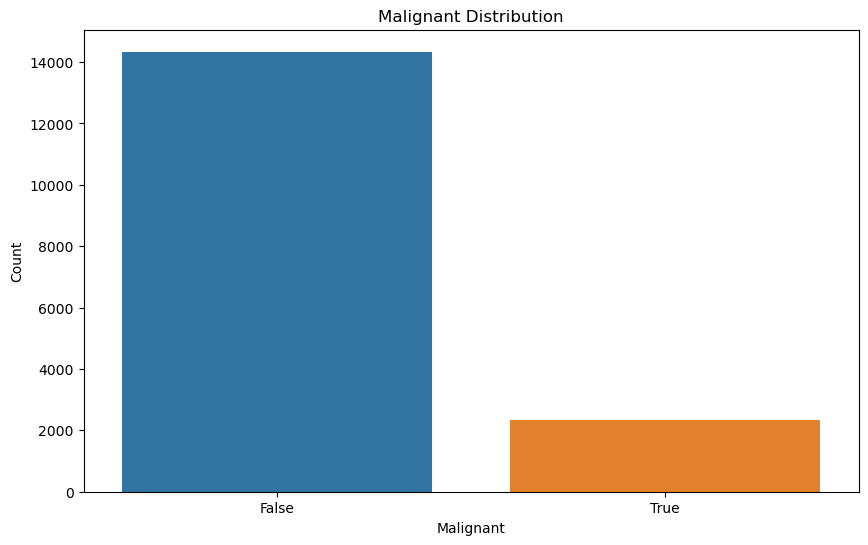

In [12]:
diagnosis = df_merged['malignant'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.barplot(x=diagnosis.index, y=diagnosis.values)
plt.title('Malignant Distribution')
plt.xlabel('Malignant')
plt.ylabel('Count')
plt.show()

In [4]:
# Information about the new dataframe:
print('Combined dataset info:')
print(df_merged.info())

Combined dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 16668 entries, 0 to 17232
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   16668 non-null  object
 1   skin_tone  16668 non-null  int64 
 2   malignant  16668 non-null  bool  
 3   path       16668 non-null  object
dtypes: bool(1), int64(1), object(2)
memory usage: 537.2+ KB
None


In [7]:
# Review paths to make sure we only have 2: (no formatting errors)
df_merged['path'].unique()

array(['raw_data/metadata/date=27-03-2024/ddi_metadata.csv',
       'raw_data/metadata/date=27-03-2024/fitzpatrick17k.csv'],
      dtype=object)

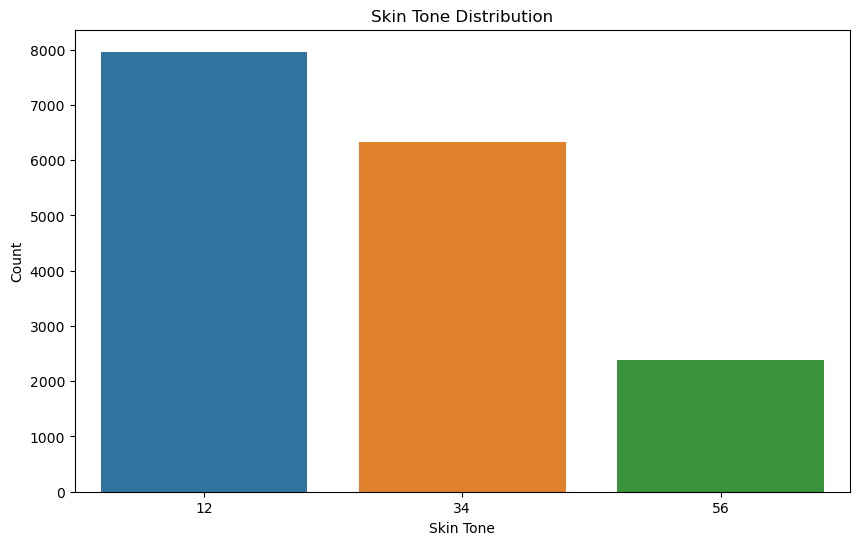

In [10]:
# Visualy inspecting unbalance:
skin_tone_counts = df_merged['skin_tone'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.barplot(x=skin_tone_counts.index, y=skin_tone_counts.values)
plt.title('Skin Tone Distribution')
plt.xlabel('Skin Tone')
plt.ylabel('Count')
plt.show()